In [4]:
import sys

import torch
import numpy as np
import mediapy as mp
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.nn import functional as F
import nbody.two_body_multi_sparse_sys as model

import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import HTML

from matplotlib.animation import FuncAnimation

torch.set_printoptions(precision=4, linewidth=500, sci_mode=True)

## Model
The model learns trajectories of two particles under a gravitational force.
The model learns and solves a second order ODE with time varying coefficients parameterized by MLPs.
$$ c_2(t;x) u'' + c_1(t;x) u' + c_0(t;x) u = b(t;x) $$
The neural network takes as input, $x$, 50-step positions and outputs an ODE for the next 50 steps. The input steps are also used as (over determined) initial conditions.
For inference, we start a given state (50 steps) and generate autoregressively.

Training and evaluation trajectories have 2000 steps each.

In [5]:
batch_size=30
#Double precision solving. Single precision is faster but solving can lead to NaN's. Lower learning rate for single precision.
solver_dbl=True 
learning_rate=0.0001

method, datamodule = model.build_model(batch_size, solver_dbl, learning_rate)

Using double precision solver


## Visualize Training Trajectory

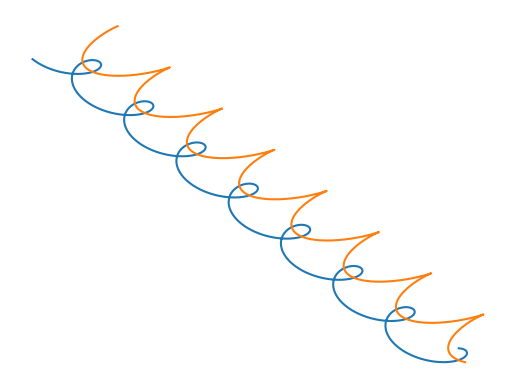

In [6]:

train_positions = datamodule.train_dataset.positions.cpu().numpy()
def plot_training(positions):
    ax = plt.subplot(1,1,1)
    #ax2 = plt.subplot(1,2,2)
    nstep=2000
    nbodies = positions.shape[1]
    
    for i in range(nbodies):
        ax.plot(positions[:nstep,i,0], positions[:nstep,i,1], label='Training {i}')
    ax.axis('off')

plot_training(train_positions.squeeze())

In [7]:
model.train(method, datamodule)

/home/apervez/miniconda3/envs/lpode/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.8 /home/apervez/miniconda3/envs/lpode/lib/python3.8 ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | EPHModel | 9.8 M 
-----------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.023    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/apervez/miniconda3/envs/lpode/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/apervez/miniconda3/envs/lpode/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/apervez/miniconda3/envs/lpode/lib/python3.8/site-packages/pytorch_lightning/loops

Training: 0it [00:00, ?it/s]

/home/apervez/miniconda3/envs/lpode/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
idx =0
device='cuda'
NS=50
@torch.no_grad()
def run_inference(method, x,v,idx, steps):
    method.to(device)
    positions = []
    velocities = []
    accs = []
    forces = []
    coeffs_list = []
    for step in range(steps):
        x = x.to(device)
        v = v.to(device)
        
        x_out, v_out = method.inference((x,v))
        
        x = x_out[:,10:NS+10,:,:]
        v = v_out[:,10:NS+10,:,:]
        
        x_out = x_out.squeeze()
        v_out = v_out.squeeze()
        
        x_out = x_out[0,NS:NS+10].squeeze(0).cpu().numpy()
        v_out = v_out[0,NS:NS+10].squeeze(0).cpu().numpy()
        
        positions.append(x_out)
        velocities.append(v_out)
    positions = np.vstack(positions)
    velocities = np.vstack(velocities)
    
    return positions, velocities

x = datamodule.val_dataset.positions
v = datamodule.val_dataset.velocities

print(x.shape)
#Batch size is fixed beforehand. TODO: fix.
#Predict starting from 50 initial steps
initial_x = x[idx:NS,:,:, :].unsqueeze(0).repeat(batch_size,1,1,1,1)
initial_v = v[idx:NS,:,: :].unsqueeze(0).repeat(batch_size,1,1,1,1)
#Generates 2000 steps
positions, velocities = run_inference(method, initial_x, initial_v,idx, steps=200)

positions.shape

torch.Size([2000, 1, 2, 2])


(2000, 2, 2)

In [9]:
val_positions = datamodule.val_dataset.positions.cpu().numpy()
val_positions.shape

positions= positions.squeeze()
val_positions = val_positions.squeeze()

## Plot and Animate Predictions

fig


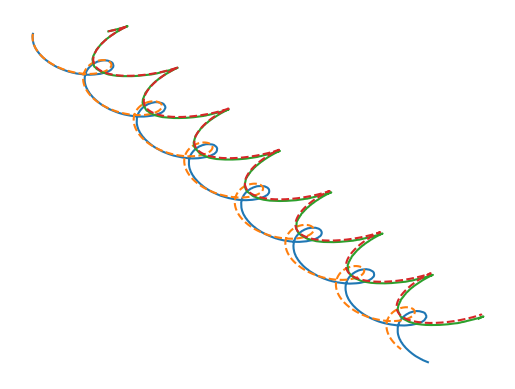

In [10]:
ax = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)
nstep=2000
nbodies = positions.shape[1]

for i in range(nbodies):
#for i in range(4,5):
    ax.plot(positions[:nstep,i,0], positions[:nstep,i,1], label='pred {i}')
    ax.plot(val_positions[NS:nstep,i,0], val_positions[NS:nstep,i,1], linestyle='--', label='Object {i}')

ax.axis('off')
print('fig')

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 50.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpto_dyu7d/temp.m4v


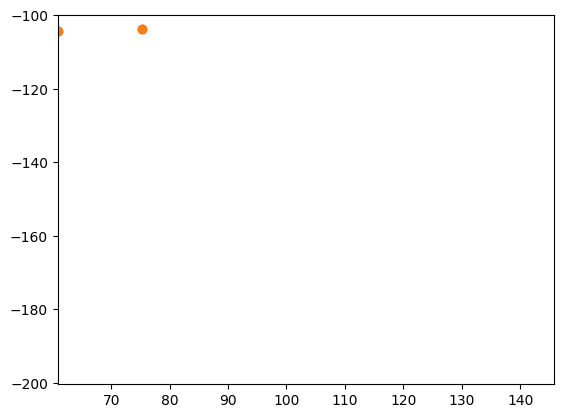

[rank: 0] Received SIGTERM: 15


In [15]:
fig, ax = plt.subplots()
def animate(t):
    
    ax.clear()
    ax.set_xlim((val_positions[:,:,0].min(),val_positions[:,:,0].max()))
    ax.set_ylim((val_positions[:,:,1].min(),val_positions[:,:,1].max()))
    
    sc = 10
    x = val_positions[NS+t*sc,:,0]
    y = val_positions[NS+t*sc,:,1]
    
    ax.scatter(x,y)
    tx = positions[t*sc,:,0]
    ty = positions[t*sc,:,1]
    
    ax.scatter(tx,ty)
anim = FuncAnimation(fig, animate, frames=150, interval=20)

HTML(anim.to_html5_video())